# Image model

This notebook will explain the process to refine the image model and it's explanations

## Import libraries

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys

from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

from captum.attr import IntegratedGradients

sys.path.append(os.path.abspath(".."))

from src.utils import load_model, set_seed
from src.data import get_dataloaders

## Auxiliary functions

In [12]:
def get_predictions(model: nn.Module, dataloader: DataLoader, device: torch.device) -> tuple:
    """
    Runs a trained model in evaluation mode over a dataloader and returns
    the predicted labels, true labels and softmax probabilities.
    Args:
    - model (nn.Module): model to evaluate
    - dataloader (Dataloader): dataloader
    - device (torch.device)
    Returns:
    tuple with predictions, targets and softmax
    """
    model.to(device)
    model.eval()

    all_preds = []
    all_targets = []
    all_softmax = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)

            all_preds.append(outputs)
            all_softmax.append(probs)

            all_targets.append(labels)

    # Concatenate all batches
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    all_softmax = torch.cat(all_softmax)

    # Get actual predicted labels
    preds_labels = torch.argmax(all_preds, dim=1).cpu().numpy()
    true_labels = all_targets.cpu().numpy()

    return preds_labels, true_labels, all_softmax

In [13]:
def show_images(df: pd.DataFrame, condition: pd.Series, title: str, n: int = 9) -> None:
    """
    Displays a grid of images sampled from a DataFrame, along with their
    true and predicted labels. The images shown are the ones that follow the condition
    Args:
    - df (pd.DataFrame)
    - condition (pandas.Series or array-like of bool)
    - title (str): title for the plot
    - n (int): number of images to display
    
    """
    subset = df[condition].sample(min(n, len(df[condition])))

    plt.figure(figsize=(10,10))
    for i, (_, row) in enumerate(subset.iterrows()):
        img = Image.open(row["image_path"]).convert("RGB")
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {row['true']} Pred: {row['prediction']}")
        plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()


In [29]:
def denormalize(images: torch.Tensor) -> np.ndarray:
    """
    Converts a batch of normalized PyTorch images back to a displayable format.

    The function assumes the images were normalized using the ImageNet statistics:
    mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225].
    Args:
    - images (torch.Tensor)
    Returns:
    - np.ndarray: denormalized images
    """
    mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    std  = np.array([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)

    imgs = images.cpu().numpy()
    imgs = imgs * std + mean
    imgs = np.clip(imgs, 0, 1)
    imgs = imgs.transpose(0, 2, 3, 1)
    return imgs


In [28]:
def overlay_image(image_1: np.ndarray, image_2: np.ndarray) -> np.ndarray:
    """
    Overlay one image to another as a heatmap
    Args:
    - image_1 (np.ndarray): base image
    - image_2 (np.ndarray): image overalyed as a heatmap
    Returns:
    - np.ndarray
    """
    image_2_gray = np.mean(np.abs(image_2), axis=0)
    image_2_gray = image_2_gray / (image_2_gray.max() + 1e-8)
    heatmap = plt.cm.inferno(image_2_gray)[:, :, :3]
    overlay = 0.6*image_1 + 0.4*heatmap
    overlay = np.clip(overlay, 0, 1)
    return overlay


In [30]:
def show_integrated_gradients(images: torch.Tensor, attrs: torch.Tensor, labels: torch.Tensor, preds: torch.Tensor, n: int = 6) -> None:

    """
    Visualizes Integrated Gradients explanations for a batch of images.

    For each sample, the function displays:
    1) the original input image,
    2) the Integrated Gradients attribution heatmap,
    3) an overlay of the heatmap on the original image.

    Args:
    - images (torch.Tensor)
    - attrs (torch.Tensor): Integrated Gradients attribution maps corresponding to the images.
    - labels (torch.Tensor)
    - preds (torch.Tensor)
    - n (int): number of images to display
    """
    class_names = ["benign", "malignant", "normal"]
    images = denormalize(images)

    plt.figure(figsize=(15, 3*n))

    for i in range(n):
        img = images[i]
        attr = attrs[i]
        overlay = overlay_image(img, attr)

        # original
        plt.subplot(n, 3, 3*i + 1)
        plt.imshow(img)
        plt.title(f"Original\nGT: {class_names[labels[i].item()]}")
        plt.axis("off")

        # heatmap
        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(attr.transpose(1,2,0), cmap="jet")
        plt.title("Integrated Gradients")
        plt.axis("off")

        # overlay
        plt.subplot(n, 3, 3*i + 3)
        plt.imshow(overlay)
        plt.title(f"Pred: {class_names[preds[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [31]:
def compute_integrated_gradients(model: nn.Module, images: torch.Tensor) -> torch.Tensor:
    """
    Computes integrated gradients for a batch of images
    Args:
    - model (nn.Module)
    - images (torch.Tensor)
    Returns:
    - torch.Tensor: normalized integrated gradients
    """
    ig = IntegratedGradients(model)
    baseline = torch.zeros_like(images)

    attributions = ig.attribute(
        images,
        baselines=baseline,
        target=torch.argmax(model(images), dim=1),
        n_steps=20
    )

    # Normalize by image
    attrs = attributions.cpu().detach().numpy()
    attrs_norm = np.zeros_like(attrs)
    for i in range(attrs.shape[0]):
        attr = attrs[i]
        attr = np.abs(attr)
        attr = attr / (attr.max() + 1e-8)
        attrs_norm[i] = attr
    
    return attrs_norm

In [34]:
def compute_global_integrated_gradients(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
    num_classes: int = 3,
    n_steps: int = 50
) -> tuple:
    """
    Computes global (class-wise) Integrated Gradients attribution maps.

    For each sample in the dataloader, Integrated Gradients are computed
    using a zero baseline and the ground-truth class as target. Attribution
    maps are aggregated per class and averaged to obtain a global
    attribution map for each class.

    Args:
    - model (nn.Module)
    - dataloader (DataLoader)
    - device (torch.device)
    - num_classes (int)
    - n_steps (int)
    Returns:
    - dict: Dictionary mapping each class index to its average attribution map of shape 
    - dict: Dictionary mapping each class index to the list of individual attribution maps
    - dict: normalized attribution intensities per class
    """

    model.eval()
    model.to(device)

    ig = IntegratedGradients(model)

    # Store per-class attributions
    all_attrs = {cls: [] for cls in range(num_classes)}

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        for i in range(images.shape[0]):
            img = images[i:i+1].float().requires_grad_(True)
            label = labels[i].item()

            baseline = torch.zeros_like(img)

            attr = ig.attribute(
                img,
                baselines=baseline,
                target=label,
                n_steps=n_steps
            )

            attr = attr.squeeze(0).detach().cpu().numpy()  # (C, H, W)

            # Channel-wise aggregation
            attr_gray = np.mean(np.abs(attr), axis=0)
            attr_gray = attr_gray / (attr_gray.max() + 1e-8)

            all_attrs[label].append(attr_gray)

    # Average attribution maps per class
    avg_attrs = {
        cls: np.mean(np.stack(all_attrs[cls]), axis=0)
        for cls in all_attrs
        if len(all_attrs[cls]) > 0
    }

    # Compute normalized intensities
    intensities = {
        cls: np.sum(avg_attrs[cls])
        for cls in avg_attrs
    }

    max_val = max(intensities.values())
    intensities_norm = {
        cls: val / max_val for cls, val in intensities.items()
    }

    return avg_attrs, all_attrs, intensities_norm


In [37]:
def visualize_global_integrated_gradients(
    avg_attrs,
    all_attrs,
    class_names,
    figsize_maps=(12, 4),
    figsize_hist=(8, 4),
    cmap="inferno",
    bins=50
):
    """
    Visualizes global Integrated Gradients attribution results.

    The function displays:
    1) The average Integrated Gradients attribution map per class.
    2) The distribution of attribution values for each class.

    Args:
    - avg_attrs (dict)
    - all_attrs (dict)
    - class_names (list)
    - figsize_maps (tuple)
    - figsize_hist (tuple)
    - cmap (str)
    - bins (int)

    """

    num_classes = len(class_names)

    # Average attribution maps 
    plt.figure(figsize=figsize_maps)
    for cls in range(num_classes):
        plt.subplot(1, num_classes, cls + 1)
        plt.imshow(avg_attrs[cls], cmap=cmap)
        plt.title(f"Integrated Gradients average \n{class_names[cls]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    #  Attribution value distributions 
    plt.figure(figsize=figsize_hist)
    for cls in range(num_classes):
        all_values = np.concatenate(
            [attr.flatten() for attr in all_attrs[cls]]
        )
        plt.hist(
            all_values,
            bins=bins,
            alpha=0.5,
            label=class_names[cls]
        )

    plt.xlabel("Attribution value")
    plt.ylabel("Frecuency")
    plt.title("Integrated gradients per class distribution")
    plt.legend()
    plt.tight_layout()
    plt.show()


## First model

I started by training and model and then analysing the results to improve it

I trained the first model using 
```bash
python -m src.train_image
```

with the following hyperparameters defined in the same file:

> epochs: int = 50  
> lr: float = 5e-4  
> batch_size: int = 32  
> dropout: float = 0.5  
> backbone: str = "resnet18"  
> augment: bool = False  
> unfreeze: bool = False  
> use_extra_conv: bool = True  
> dropout: float = 0.5  

The results were:

> **Train Accuracy:**   100.00%  
> **Val Accuracy:**  69.23%  
> **Test Accuracy:**  69.23%  

With this results, the model was clearly overfitting. The confusion matrix is:

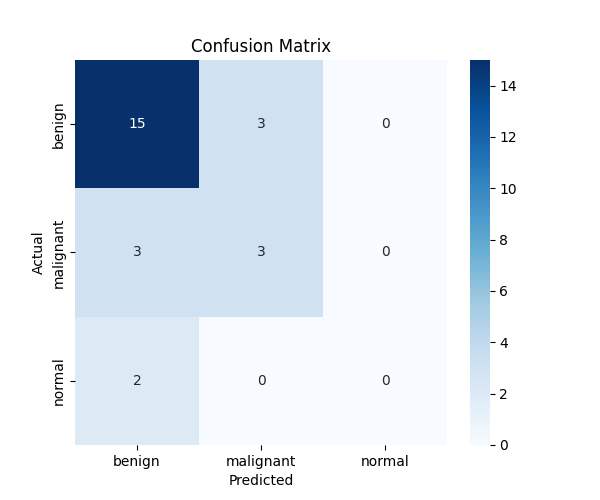

In [14]:
display(Image(filename="../results/Image_model_lr_0.0005_bs_32_back_resnet18_drop_0.5_unfreeze_False_extrconv_True_augment_False_confusion_matrix.png"))

Then, I explored the results to try and find a way to improve the model's performance

I started by visualizing the probability distribution the model was giving to each prediction in test, to see if the model was mostly predicting benign as in the class distribution there are far more benign images than malignant or normal

In [ ]:
device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

info_file: str = "../data/BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
images_folder: str = "../data/BrEaST-Lesions_USG-images_and_masks/"

model_name: str = "Image_model_lr_0.0005_bs_32_back_resnet18_drop_0.5_unfreeze_False_extrconv_True_augment_False"

model: nn.Module = load_model(model_name)
model.to(device)
model.eval()
print("Model loaded")

Model loaded


c:\Users\User\Documents\Primero\etica_y_explicabilidad\Practicas\final-project-sofiapedros\src\data.py:96: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.tabular_df[col] = self.tabular_df[col].replace(


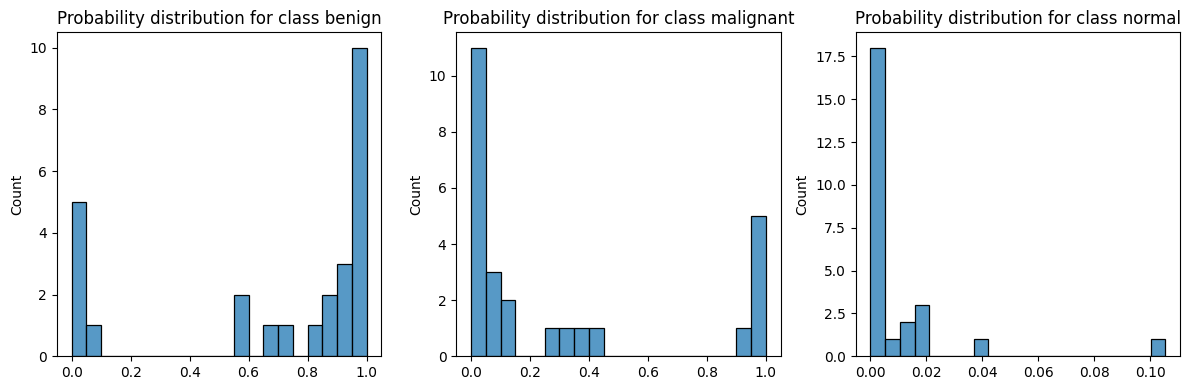

In [ ]:
test_loader: DataLoader
_ , _, test_loader = get_dataloaders(
        info_file, images_folder, batch_size=32, seed=42, type="image"
    )

# Read data
df: pd.DataFrame = pd.read_excel(info_file, sheet_name='BrEaST-Lesions-USG clinical dat')
df = df.dropna(subset=["Classification"])
class_map: dict = {'benign': 0, 'malignant': 1, 'normal': 2}

# Complete the dataframe with information aboat label, image_path, prediction and probabilities
df["label"] = df["Classification"].map(class_map)
df["image_path"] = df["Image_filename"].apply(lambda x: os.path.join(images_folder, x))
test_indices = test_loader.dataset.indices
test_df: DataLoader = df.iloc[test_indices].reset_index(drop=True)
preds_labels, true_labels, softmax_scores = get_predictions(model, test_loader, device)
test_df["prediction"] = preds_labels
test_df["true"] = true_labels
test_df["probs"] = softmax_scores.cpu().numpy().tolist()

probs = np.array(test_df["probs"].tolist())

# Plot the results
plt.figure(figsize=(12,4))
for i, cls in enumerate(["benign", "malignant", "normal"]):
    plt.subplot(1,3,i+1)
    sns.histplot(probs[:,i], bins=20)
    plt.title(f"Probability distribution for class {cls}")
plt.tight_layout()
plt.show()


As expected, we can see that the proability distribution for benign clearly is closer to 1 than the others, and the model barely classifies anything as normal.

I also looked at the precision-recall curve per class:

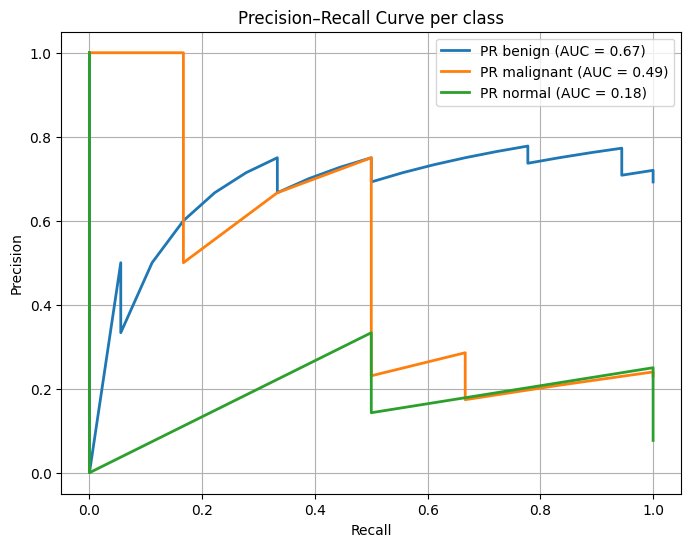

In [26]:
classes = ["benign", "malignant", "normal"]
n_classes = 3
y_true_bin = label_binarize(true_labels, classes=[0,1,2])
y_score = softmax_scores.cpu().numpy()

plt.figure(figsize=(8,6))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, lw=2,
             label=f"PR {classes[i]} (AUC = {pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve per class")
plt.legend()
plt.grid(True)
plt.show()


We can see that the model works better classifying benign samples (highest AUC). From the others AUC, we can confirm that clearly the model is biased towards benign and the model can not distinguish effectively normal and/or malignant samples.

Finally, I wanted to see what the model was paying attention to in the prediction, to see if there are any specific regions the model looks at for predicting or the model had just learned the training dataset, without learning any useful patterns. For that, after looking at some images from the dataset, I decided to use Integrated gradients (a mean across all images) to see the collaboration of each pixel for the final prediction (because the images looked like they could be overlapped, so the interest regions could be the same for all images)

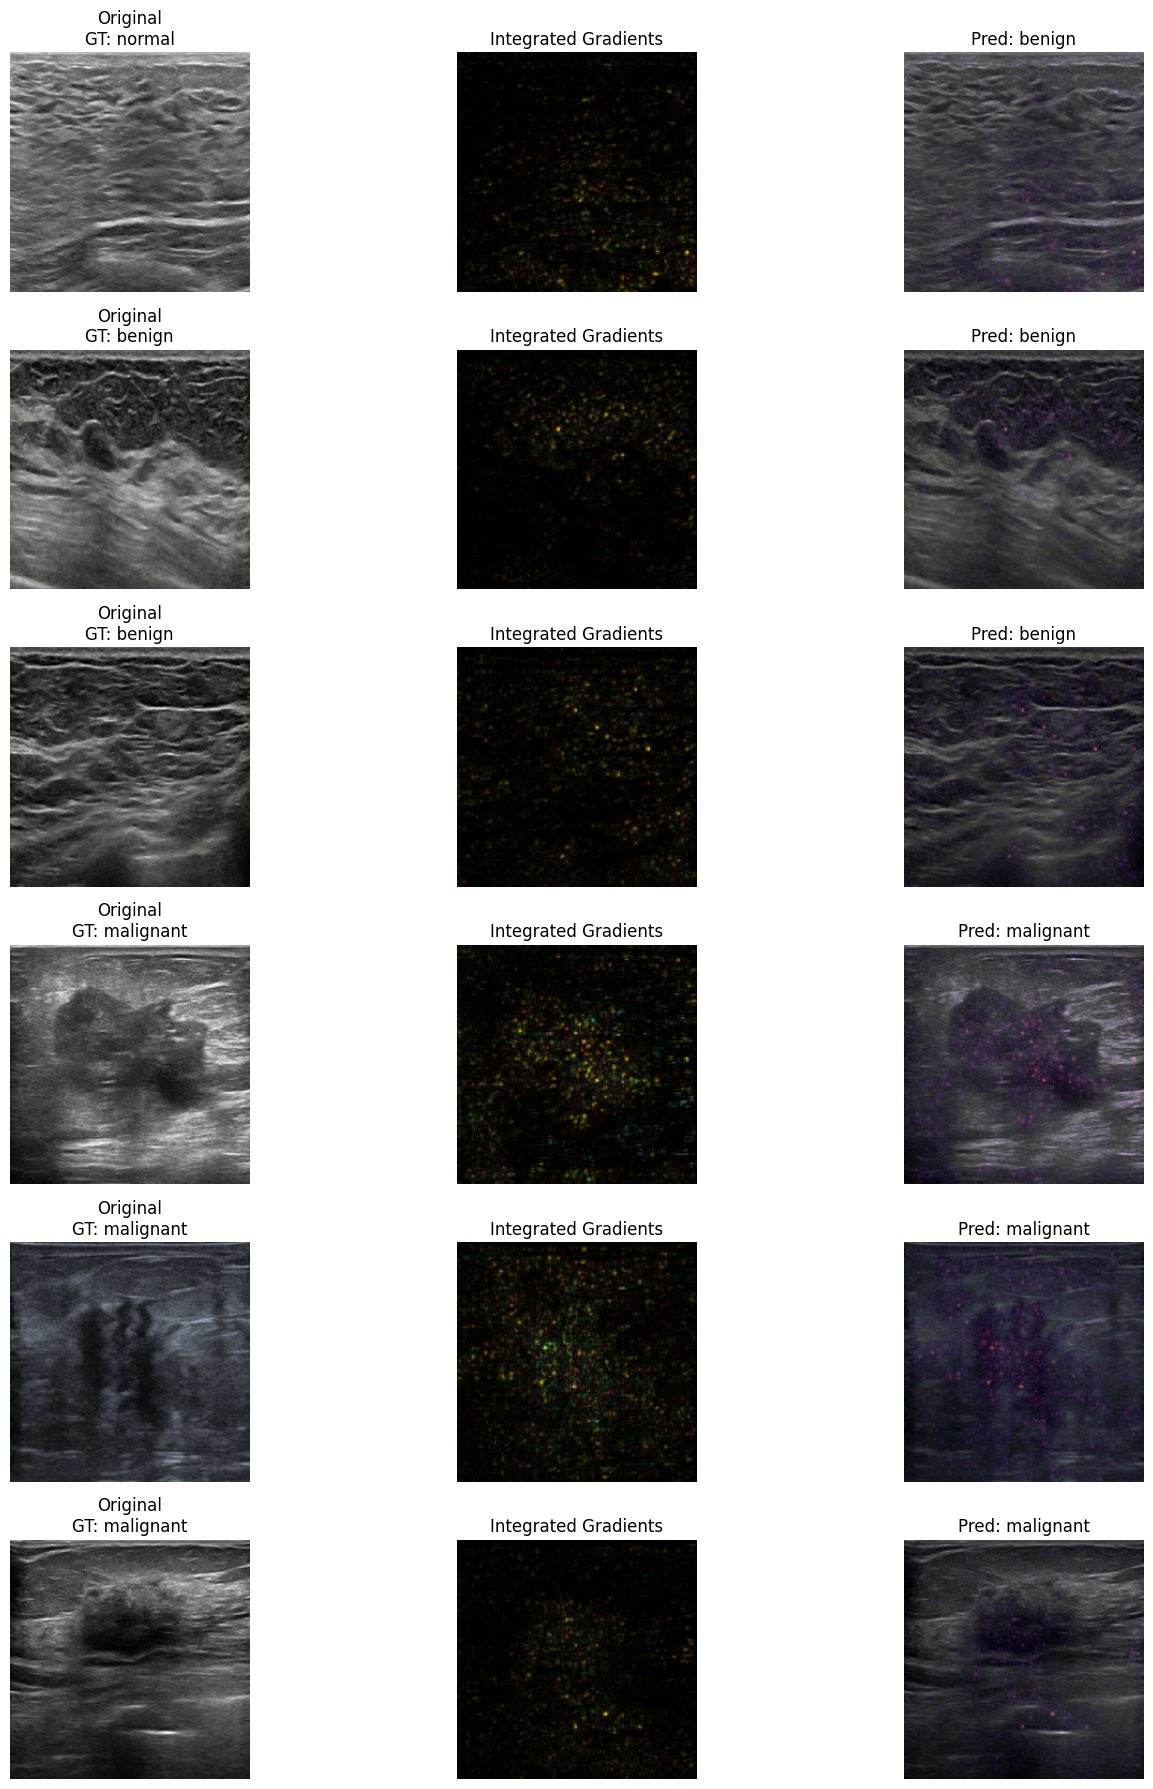

In [33]:
# Get a set of images
images, labels = next(iter(test_loader))
images = images.cpu().float().requires_grad_(True)
labels = labels.cpu()

model.to("cpu")
attrs = compute_integrated_gradients(model, images)

with torch.no_grad():
    output = model(images)
    preds = torch.argmax(output, dim=1).cpu().numpy()
 
show_integrated_gradients(images.detach(), attrs, labels, preds, n=6)


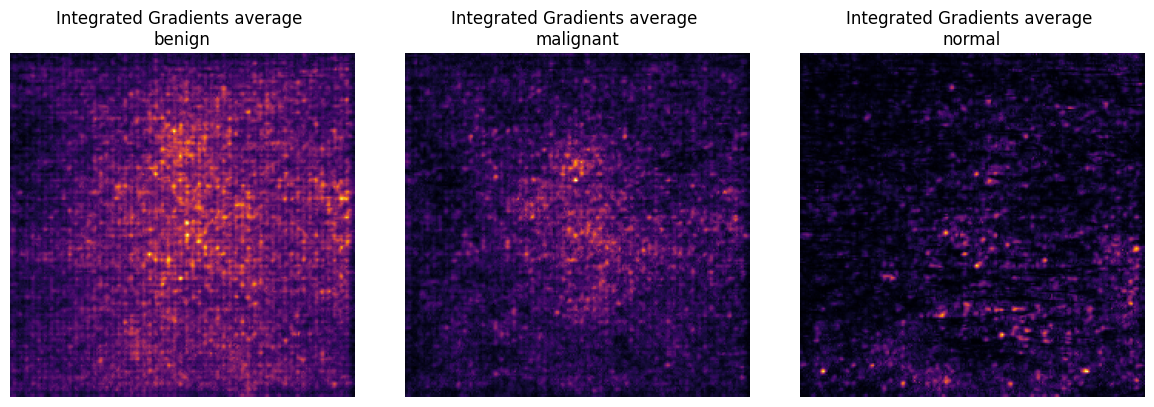

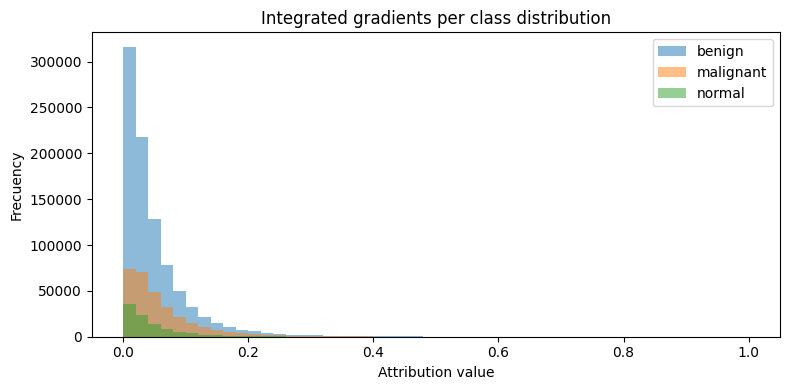

In [38]:
avg_attrs, all_attrs, intensities = compute_global_integrated_gradients(
    model,
    test_loader,
    device,
    num_classes=3
)

visualize_global_integrated_gradients(
    avg_attrs,
    all_attrs,
    class_names=["benign", "malignant", "normal"]
)


From this results and the above, I could see that mostly everything was zero and that the model was clearly biased towards benign which was the mayoritary class in the dataset. For that reason, I decided to do some data augmentation in the dataset to try and avoid the bias so that the model could learn some useful detection patterns.